##  Regression:Tutors - expected math exam results
Predict average math exam results for students of the tutors - https://www.kaggle.com/c/tutors-expected-math-exam-results

#### Rules: You can only use these imports:

import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import seaborn as sns

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# уменьшение потребляемой памяти
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Обзор данных

In [3]:
df_train = pd.read_csv('C:/Users/yana/4/train.csv')
df_test = pd.read_csv('C:/Users/yana/4/test.csv')
predictions = pd.DataFrame()
predictions['Id'] = df_test['Id'].copy()
#reduce_mem_usage(df_train)
#reduce_mem_usage(df_test)

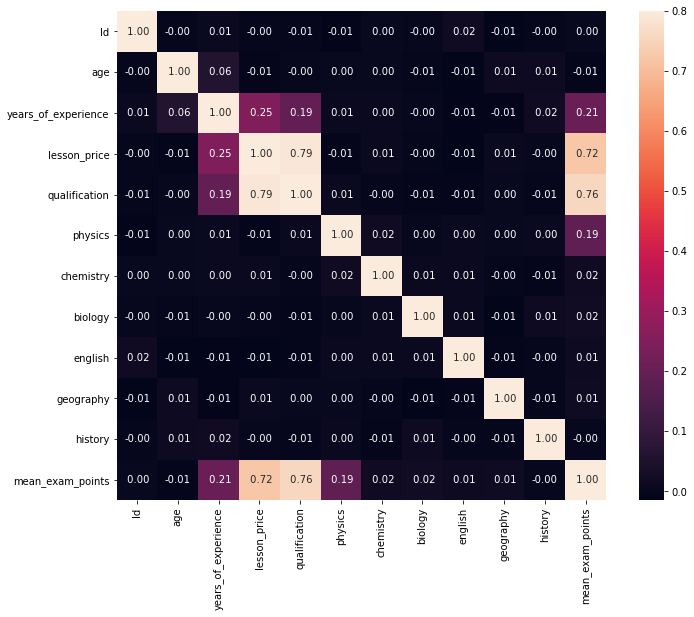

In [4]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_train.corr(), vmax=.8, annot=True, fmt=' .2f', square=True);

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


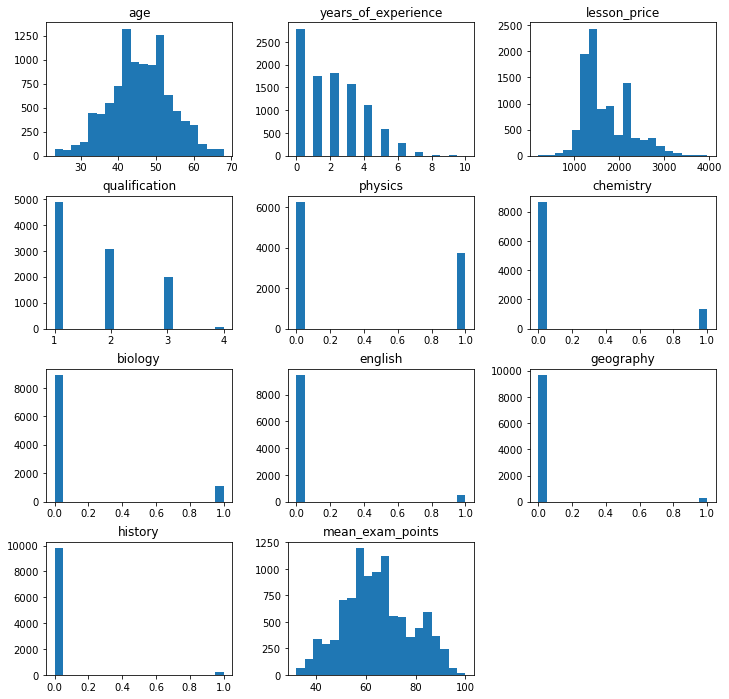

In [6]:
features = df_train.drop(['Id'], axis=1, inplace=False)
features.hist(figsize=(12,12), bins=20, grid=False);

## Подготовка данных и создание новых признаков

In [7]:
class Dataset:
    
    def __init__(self):
        self.age1 = None
        self.age2 = None
        self.age3 = None
        self.age4 = None

        
    def fit(self, df):
        self.age1 = np.quantile(df['age'], q=0.025)
        self.age2 = np.quantile(df['age'], q=0.16)
        self.age3 = np.quantile(df['age'], q=0.84)
        self.age4 = np.quantile(df['age'], q=0.975)
        self.sum = (df['qualification'] * (df['lesson_price']//100)).sum()

        
    def transform(self, df):
        df = df.astype('int')

        df['age_cat'] = 0
        df.loc[df['age'] < self.age1, 'age_cat'] = 1
        df.loc[(df['age'] >=self.age1) & (df['age'] < self.age2), 'age_cat'] = 2
        df.loc[(df['age'] >=self.age2) & (df['age'] < self.age3), 'age_cat'] = 3
        df.loc[(df['age'] >=self.age3) & (df['age'] <= self.age4), 'age_cat'] = 4
        df.loc[df['age'] > self.age4, 'age_cat'] = 1
        df['age'] = df['age']//10
                
        df['lesson_price'] = df['lesson_price']//100

        df['qual&price1'] = df['qualification'] / df['lesson_price']
        df['qual&price2'] = df['qualification'] * df['lesson_price']
   
        df['experienced'] = df['years_of_experience']+df['qualification']
        df['exp_price'] = df['experienced']*df['lesson_price']

        df['q_pr_sum'] = df['qual&price2']  / self.sum

        df['other'] = df['chemistry']+df['biology']+ df['history']+ df['english']+ df['geography']
        df.drop(['Id', 'chemistry', 'biology', 'history', 'english', 'geography'], axis=1, inplace=True)

        
        return df

In [8]:
data = Dataset()
data.fit(df_train)
df_train = data.transform(df_train)
df_test = data.transform(df_test)

In [9]:
reduce_mem_usage(df_train)
reduce_mem_usage(df_test)

Memory usage of dataframe is 0.61 MB
Memory usage after optimization is: 0.20 MB
Decreased by 67.2%
Memory usage of dataframe is 0.57 MB
Memory usage after optimization is: 0.19 MB
Decreased by 66.7%


,age,years_of_experience,lesson_price,qualification,physics,age_cat,qual&price1,qual&price2,experienced,exp_price,q_pr_sum,other
0,4,3,10,1,0,3,0.100000,10,4,40,0.000031,1
1,4,3,18,2,0,3,0.111111,36,5,90,0.000112,0
2,5,1,15,1,1,3,0.066667,15,2,30,0.000047,0
3,5,6,29,3,1,4,0.103448,87,9,261,0.000271,1
4,4,4,31,3,1,3,0.096774,93,7,217,0.000290,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4,0,15,1,0,3,0.066667,15,1,15,0.000047,0
9996,5,2,22,3,0,3,0.136364,66,5,110,0.000206,1
9997,3,5,11,1,0,2,0.090909,11,6,66,0.000034,0
9998,4,0,17,2,0,3,0.117647,34,2,34,0.000106,0


In [10]:
X = df_train.drop(['mean_exam_points'], axis=1, inplace=False).to_numpy()
y = df_train['mean_exam_points'].to_numpy()
X_fin = df_test.to_numpy()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

## Gradient Boosting Regressor

In [12]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        preds = np.mean(self.labels)
        return preds


In [13]:
class Tree:
    
    def __init__(self, depth=6, min_leaf=6):
        self.depth = depth
        self.min_leaf = min_leaf
        self.tree = None
        
    def var(self, x):
        return np.var(x)


    def quality(self, left_labels, right_labels, current_var):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current_var - p * self.var(left_labels) - (1 - p) * self.var(right_labels)


    # Разбиение датасета в узле

    def split(self, data, labels, index, t):
    
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
        
        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]
        
        return true_data, false_data, true_labels, false_labels


    # Нахождение наилучшего разбиения

    def find_best_split(self, data, labels):
    
        #  обозначим минимальное количество объектов в узле

        current_var = self.var(labels)

        best_quality = 0
        best_t = None
        best_index = None
    
        n_features = data.shape[1]
    
        for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])
        
            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue
            
                current_quality = self.quality(true_labels, false_labels, current_var)
            
                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index


    # Построение дерева с помощью рекурсивной функции

    def fit(self, data, labels, depth=-1):
        if depth==-1:
            depth = self.depth
        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)
    
        # ограничение глубины
        if depth ==0:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        depth -=1
        true_branch = self.fit(true_data, true_labels, depth)
        false_branch = self.fit(false_data, false_labels, depth)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.tree = Node(index, t, true_branch, false_branch)
        return Node(index, t, true_branch, false_branch)




    def classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
    
    
    def predict(self, data):
    
        results = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            results.append(prediction)

        return results
        
    

In [14]:
class GradientBoostingRegressor:
    
    def __init__(self, n_trees, max_depth, min_leaf, coefs, eta):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_leaf = min_leaf
        self.coefs = coefs
        self.eta = eta
        self.trees = []
    

    def bias(self, y, z):
        return (y - z)


    def fit(self, X_train, y_train):
    
        for i in range(n_trees):

            if len(self.trees) == 0:
                # обучаем первое дерево на обучающей выборке
                tree= Tree(self.max_depth, self.min_leaf)
                tree.fit(X_train, y_train)          
            
            else:
            # Получим ответы на текущей композиции
                target = self.predict(X_train)
            
                # алгоритмы начиная со второго обучаем на сдвиг
                tree=Tree(self.max_depth, self.min_leaf)
                tree.fit(X_train, self.bias(y_train, target))

            self.trees.append(tree)


    def predict(self, X):   
        
        
    
        return np.array([sum(((1 if i==0 else self.eta)* coef * alg.predict([x])[0] 
                          for i, (alg, coef) in enumerate(zip(self.trees, self.coefs)))) 
                     for x in X])
    

## Обучение модели и оценка результата

In [15]:
n_trees = 15
coefs = [1] * n_trees
eta=0.5
gb_model = GradientBoostingRegressor(n_trees = n_trees, max_depth=4, min_leaf=4, coefs = coefs, eta = eta)
gb_model.fit(X_train, y_train)

In [16]:
preds_train = gb_model.predict(X_train)
preds_test = gb_model.predict(X_test)

In [17]:
def r2(y, predictions):
    return 1 - (sum((y-predictions)**2) / sum((y-np.mean(y))**2))

In [18]:
print(r2(y_train, preds_train))
print(r2(y_test, preds_test))

0.796713248188673
0.7764267097381079


In [19]:
n_trees = 260  
coefs = [1] * n_trees
eta=0.2
gb_model = GradientBoostingRegressor(n_trees = n_trees, max_depth=2, min_leaf=4, coefs = coefs, eta = eta)
gb_model.fit(X, y)

In [20]:
preds_train = gb_model.predict(X)
preds_test = gb_model.predict(X_fin)
print(r2(y, preds_train))

0.7937293588793177


In [21]:
predictions['mean_exam_points'] = preds_test
predictions.to_csv('./predictions_regression.csv', index=False, encoding='utf-8', sep=',')
predictions.head(6)

,Id,mean_exam_points
0,10000,55.538035
1,10001,63.804233
2,10002,50.373222
3,10003,91.800872
4,10004,88.949405
5,10005,63.358592
